In [48]:
import keras
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from scipy.special import softmax

# Example Bid Price, Moving Up

Neural network modelling p(Y = y1 |Y >= y1, X=x)

There can be zero levels both in the spread as well as in the bid and ask sides. Furthermore, many changes are happening within our 100ms snapshot window. I thus see two ways by which to calculate the price level change:

#### 1.
As the price is to 0.01 accuracy one can simply take the difference in the best bid price and multiply by 100 to get it in the terms of how many $ \$ 0.01$ levels it has increased by.
$
#### 2.
Or one can approximate the price level change by taking that which is closest to the current non-zero levels present.
 e.g. if the bid price moves up in the next step to 5.20 and at the current time step there are ask price levels at 5.15, 5.18, 5.22, ... then there will be a price level increase of 2 levels. This seems somewhat more arbitrary and heavily dependent on the current state of the orderbook.
 
$\textbf{This is one of the things I am not sure about but I have assumed the first method}$
$\textbf{of defining price level change.}$

The file "df_snapshot_100_ms_bid_up.csv" uses the first approach of seeing levels as the $\$0.01$ differences. It includes only the snapshots for which a bid price increase was observed.

In [95]:
df_bid_up = pd.read_csv('df_snapshot_100ms_bid_up.csv', index_col='timestamp')
df_bid_up.head()

,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8,bq9,bq10,...,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,bid_change_n
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-12 00:00:10.300,0.020000,0.093829,1.000000,0.023100,2.859000,1.083058,0.0600,1.000000,0.1000,2.45536,...,2.500,0.896321,0.001,0.766000,0.001737,1.820000,0.933419,2.297440,0.052000,1.0
2019-11-12 00:00:19.300,5.898437,0.103284,2.862000,1.000000,0.023100,4.100000,1.0000,0.100000,0.0600,2.06466,...,2.600,0.005000,2.500,1.236624,0.010000,0.001000,0.766000,0.001737,1.820000,4.0
2019-11-12 00:00:19.400,2.000000,0.881936,2.000000,4.658088,2.862000,1.000000,0.0231,4.100000,1.0000,0.10000,...,8.200,2.203000,2.600,0.005000,2.500000,1.236624,0.010000,0.001000,0.766000,3.0
2019-11-12 00:00:19.500,1.901425,2.286003,2.120276,2.000000,2.658088,2.862000,1.0000,0.103284,0.0231,4.10000,...,2.203,2.600000,0.005,2.500000,1.236624,0.010000,0.001000,0.766000,0.001737,3.0
2019-11-12 00:00:19.600,2.200000,2.000000,2.000000,2.860000,0.120276,2.658088,1.0000,0.103284,0.0231,4.10000,...,2.203,2.600000,0.005,2.500000,1.236624,0.010000,0.001000,0.766000,0.001737,4.0


In [5]:
len(df_bid_up)

453877

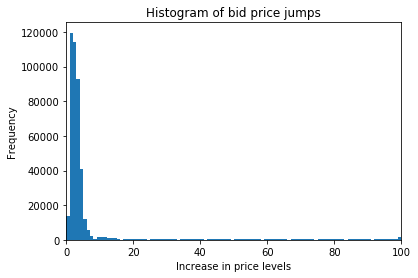

In [3]:
# Make sure to use values.astype(int) and round as otherwise 0.99 goes to 0 and many are approximately 1. Although for bins it doens't matter.
value_counts = np.unique(np.round(df_bid_up['bid_change_n'].values).astype(int), return_counts=True)
plt.hist(df_bid_up['bid_change_n'], bins=100, range=(0,100))
plt.xlabel('Increase in price levels')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.title('Histogram of bid price jumps')
plt.show()

As the neural network models conditional probabilities, the conditional increase $y_1>=1$ is also an input to the neural network $f_\theta^{1,-}(x,y_1)$. This means for every row, n duplicates can be made with $y_1$ increasing from 1 to the amount of levels it actually moves. As can be seen in the histogram above, although in most snapshots the price level change is only around 5-10, there are some snapshots where there are increases of 100 or more (max price level change is 2733 (see value_counts)). Duplicating that many rows seems somewhat bad so I could simply duplicate the rows of those snapshots that only increase by say max 20 price levels. This would however have a big effect on the accuracy of the model in the tails of the distribution. As this is of particular importance in risk modelling, this isn't a great way to do it I think. Also there wouldn't be very many datapoints to predict the probabilities given it has increased by a large amount. Although I guess this is also less important.

$\textbf{This is the second thing I'm not really sure about}.$

Sirignano's paper argues the following:

$p(Y_1 = y_m | X=x) = p(Y_1 = y_m | Y_1 \geq y_m, X=x)p(Y_1 \geq y_m |X=x)$

Instead I will implement the following for cases where $y_m \geq 20$:

$p(Y_1 = y_m | X=x) = p(Y_1 = y_m | Y_1 \geq 20, X=x)p(Y_1 \geq 20 |X=x)$

Importantly, this means that the input $y_1$ will not exceed 20 for any case.

For various reasons will also get rid of all datapoints which jump by more than 100 levels. This represents around 0.8% of data but a massive proportion of the number of classes.

For now actually get rid of datapoints which jump by more than 20 levels. This keeps 60% of the data.

In order to advance however, I will cap the duplication of the rows of snapshots to 20.:

In [96]:
# Drop the timestamp as this is not important
df_bid_up.reset_index(drop=True, inplace=True)

# Round the bid_change_n to the nearest integer than convert type to int
df_bid_up['bid_change_n'] = np.round(df_bid_up['bid_change_n'].values).astype(int)
df_bid_up = df_bid_up[df_bid_up['bid_change_n'] <= 20]

# Cap the duplication to 20 rows
reps = np.clip(df_bid_up['bid_change_n'].values,a_min=1, a_max=20)

# List of indices, if want to repeat twice will appear twice but max 20x.
df_bid_up_reps = df_bid_up.loc[np.repeat(df_bid_up.index.values, reps)]

In [97]:
# Forming y1_cond from the bid change_n, add to dataframe
y1_cond = [ind for val in df_bid_up['bid_change_n'].values for ind in list(range(1,min(20,val)+1))]
df_bid_up_reps['y1_cond'] = y1_cond

#Reset index
df_bid_up_reps.reset_index(drop=True, inplace=True)

This is now the full dataframe in theory (I think) with the bid_change_n being the y variable and the rest the X dataframe.

In [98]:
X = df_bid_up_reps.drop('bid_change_n', axis=1)
y = df_bid_up_reps['bid_change_n']
print(X.shape, y.shape)
X.head()

(1182916, 101) (1182916,)


,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8,bq9,bq10,...,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,y1_cond
0,0.020000,0.093829,1.000,0.0231,2.8590,1.083058,0.06,1.0,0.10,2.45536,...,2.5,0.896321,0.001,0.766000,0.001737,1.820,0.933419,2.297440,0.052,1
1,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,1
2,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,2
3,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,3
4,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,4


In [99]:
unique = np.unique(y.values, return_counts=True)
a = {unique[0][i] : unique[1][i] for i in range(0,len(unique[0]))}
unique

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 array([105912, 212206, 277236, 278924,  65740,  52536,  25900,  15016,
         13437,  17450,  16280,  13956,  13650,  11396,  10965,  10176,
          9775,   9756,  10545,  12060], dtype=int64))

In [100]:
# to_categorical converts class vector into matrix from 0 to num_classes hence minus 1
y_cat = to_categorical(y.values-1)
np.shape(y_cat)

(1182916, 20)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y_cat,
                                                    test_size=0.2)

Model specifications in paper:

4 layers
hidden units as tanh function
50 neurons per hidden layer
trained for 75 epochs

batch normalisation
RMSProp algorithm for training
adaptive learning rate
early stopping
$l^2$ penalty

In [106]:
model = Sequential()
model.add(Dense(50, input_shape=(101,), activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(20, activation='tanh'))

model.compile(RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [107]:
model.fit(X_train, y_train, epochs=5, validation_split=0.1)

Train on 851698 samples, validate on 94634 samples
Epoch 1/5
851698/851698 [==============================] - 137s 160us/step - loss: 7.4569 - accuracy: 0.0831 - val_loss: 7.2825 - val_accuracy: 0.0861
Epoch 2/5
851698/851698 [==============================] - 109s 128us/step - loss: 7.1858 - accuracy: 0.0719 - val_loss: 7.1211 - val_accuracy: 0.0824
Epoch 3/5
851698/851698 [==============================] - 124s 146us/step - loss: 7.1340 - accuracy: 0.0691 - val_loss: 7.5712 - val_accuracy: 0.1317
Epoch 4/5
851698/851698 [==============================] - 104s 122us/step - loss: 7.1346 - accuracy: 0.0608 - val_loss: 7.0681 - val_accuracy: 0.0815
Epoch 5/5
851698/851698 [==============================] - 101s 119us/step - loss: 7.1651 - accuracy: 0.0867 - val_loss: 7.5499 - val_accuracy: 0.0857


In [28]:
y_pred = model.predict(X_test)

In [29]:
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

In [45]:
print(classification_report(y_test_class, y_pred_class))

c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21306
           1       0.00      0.00      0.00     42247
           2       0.00      0.00      0.00     55419
           3       0.16      1.00      0.28     55896
           4       0.00      0.00      0.00     13118
           5       0.00      0.00      0.00     10579
           6       0.00      0.00      0.00      5198
           7       0.00      0.00      0.00      3057
           8       0.00      0.00      0.00      2736
           9       0.00      0.00      0.00      3490
          10       0.00      0.00      0.00      3274
          11       0.00      0.00      0.00      2766
          12       0.00      0.00      0.00      2678
          13       0.00      0.00      0.00      2375
          14       0.00      0.00      0.00      2187
          15       0.00      0.00      0.00      2084
          16       0.00      0.00      0.00      1938
          17       0.00    

In [34]:
confusion_matrix(y_test_class, y_pred_class)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

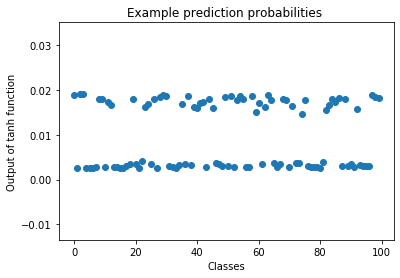

In [55]:
plt.scatter(range(0,100),softmax(y_pred[0,:]))
plt.ylabel('Output of tanh function')
plt.xlabel('Classes')
plt.title('Example prediction probabilities ')
plt.show()

In [94]:
df_X_test = pd.DataFrame(data=X_test, columns=X.columns)
df_X_test.head()

,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8,bq9,bq10,...,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,y1_cond
0,0.183577,1.507875,0.500000,2.100000,2.000000,2.918,0.184587,0.608861,0.533285,0.040000,...,0.100,0.0500,0.010000,0.001,0.011079,1.066000,0.077672,0.098656,0.100000,4.0
1,0.366582,14.316389,0.186582,2.000000,0.562034,4.500,0.077994,0.300000,7.400000,0.040000,...,5.000,0.1574,0.158085,3.200,0.835094,0.731420,0.101000,0.782604,0.200000,6.0
2,0.085818,0.138147,0.461688,0.398700,1.000000,0.080,0.196465,0.800000,0.040000,1.000000,...,0.004,0.2500,0.904599,2.200,0.302393,0.600000,0.420795,1.011000,0.007469,2.0
3,0.500000,2.090432,2.000000,0.364793,0.184793,0.200,0.022260,1.000000,0.073678,0.038619,...,2.380,1.4210,0.764000,0.600,3.120000,4.990908,2.283413,0.056589,0.836083,7.0
4,0.747182,2.200000,2.000000,2.000000,0.082602,0.068,0.120000,0.990832,0.040000,0.005000,...,2.000,0.2335,2.371745,8.200,2.640000,1.066535,2.700000,3.000000,0.686080,2.0


In [93]:
y_pred

array([[ 0.9896088 , -0.999951  ,  0.99978125, ...,  0.98836726,
         0.969835  ,  0.95229125],
       [ 0.9900903 , -0.99995446,  0.99979013, ...,  0.9883347 ,
         0.9696214 ,  0.95103836],
       [ 0.9902758 , -0.9999451 ,  0.9997718 , ...,  0.98649234,
         0.966923  ,  0.947864  ],
       ...,
       [ 0.98972607, -0.99995255,  0.9997757 , ...,  0.9873505 ,
         0.9711123 ,  0.9523374 ],
       [ 0.9898974 , -0.9999502 ,  0.9997563 , ...,  0.98807716,
         0.9694349 ,  0.9537922 ],
       [ 0.99084747, -0.99994683,  0.99977446, ...,  0.98676234,
         0.9674972 ,  0.9520482 ]], dtype=float32)